# Лабораторная 15-17. Кластеризация.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, fetch_20newsgroups, make_moons
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore

from ucimlrepo import fetch_ucirepo 

from shapely.geometry import Point

## k-Means.

### Задание 1. Сегментация.
Используйте встроенный в библиотеку seaborn датасет "penguins" для задачи кластеризации. Ваша задача - сегментировать пингвинов с использованием K-means.
Попробуйте иерархическую классификацию и DBSCAN на тех же данных и сравните результаты.

In [113]:
df_penguins = sns.load_dataset('penguins')

df_penguins.head(7)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female


In [114]:
df_penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [115]:
df_penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [116]:
df_penguins = df_penguins.dropna()

df_penguins.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [117]:
df_penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


In [118]:
def elbow(X, start=1, end=10):
    inertia = []

    k_range = range(start, end)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        inertia.append(kmeans.inertia_)

    plt.plot(k_range, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

In [119]:
X, y = df_penguins.drop(columns=['species']), df_penguins.species

In [120]:
X_encoded = pd.get_dummies(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

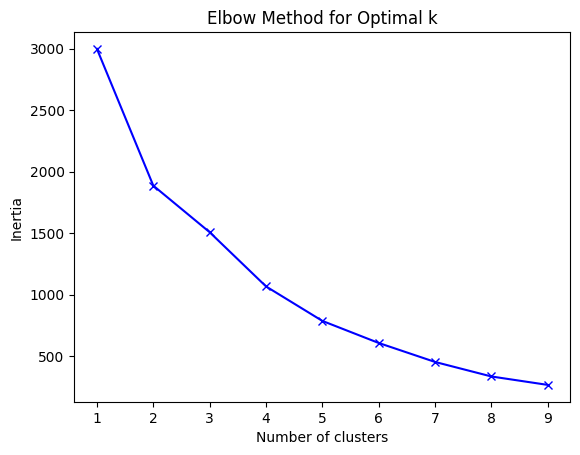

In [121]:
elbow(X_scaled)

In [122]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_penguins['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

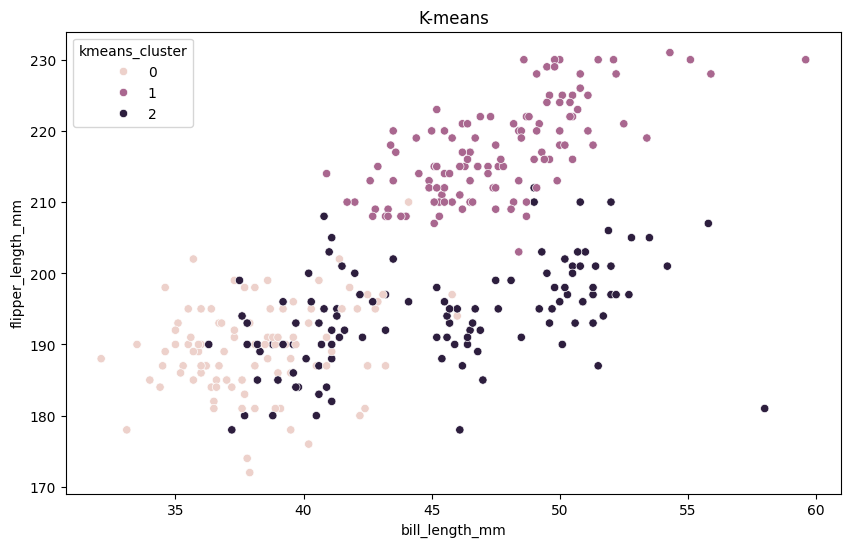

In [123]:
plt.figure(figsize=(10,6))

plt.title('K-means')

sns.scatterplot(x='bill_length_mm', y='flipper_length_mm', hue='kmeans_cluster', data=df_penguins)
plt.show()

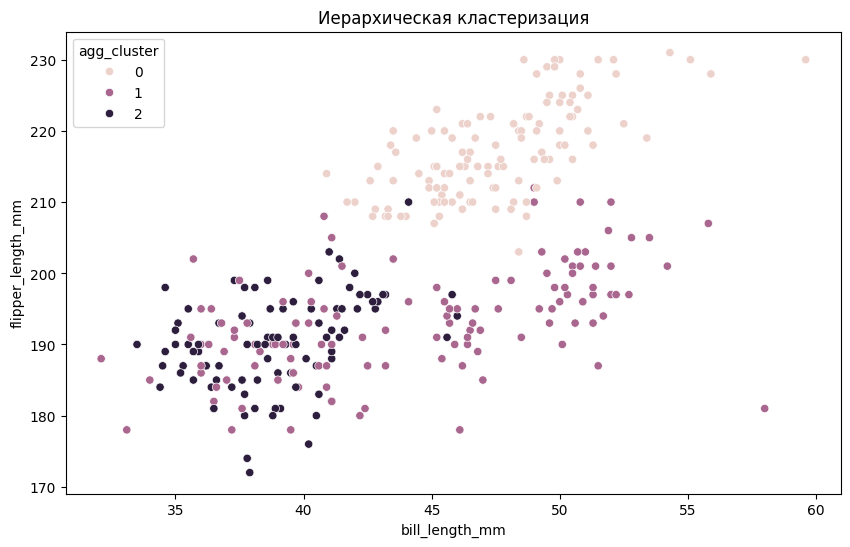

In [124]:
agg = AgglomerativeClustering(n_clusters=3)

df_penguins['agg_cluster'] = agg.fit_predict(X_scaled)

plt.figure(figsize=(10,6))

plt.title('Иерархическая кластеризация')

sns.scatterplot(x='bill_length_mm', y='flipper_length_mm', hue='agg_cluster', data=df_penguins)
plt.show()

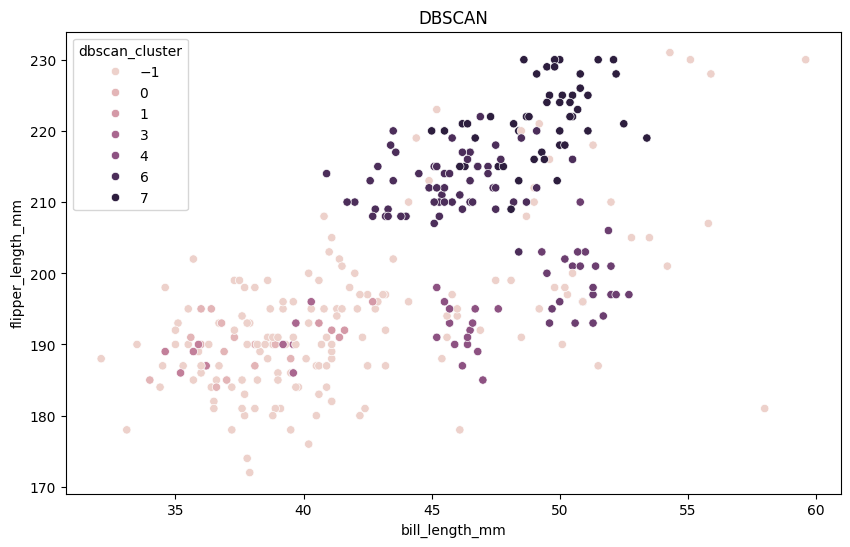

In [125]:
dbscan = DBSCAN()

df_penguins['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10,6))

plt.title('DBSCAN')

sns.scatterplot(x='bill_length_mm', y='flipper_length_mm', hue='dbscan_cluster', data=df_penguins)
plt.show()

### Задача 3. Кластеризация текстовых данных (новостных заголовков).
Вам нужно скачать [News Aggregator Dataset](https://www.kaggle.com/uciml/news-aggregator-dataset) с Kaggle, предварительно обработать текст новостных заголовков и провести кластеризацию с использованием K-Means. Целью этой задачи является группировка похожих новостей в одном кластере.

In [131]:
df_news = pd.read_csv(r'Datasets\News.zip').sample(2000)

df_news.head(7)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
387190,387650,Malaysian PM says shocked by report plane has ...,http://geo.tv/article-154151-Malaysian-PM-says...,"Geo News, Pakistan",b,dLIkfTlxDackGzMY7XjuIZPk5uVWM,geo.tv,1405620935626
154671,155007,Shakespeare's Globe theatre to take 'Hamlet' t...,http://www.ctvnews.ca/entertainment/shakespear...,CTV News,e,dzI-ENgxCcPY0jM3l1xD8KmQdIspM,www.ctvnews.ca,1398287810860
256003,256449,Iran Wants 'Zionist' Facebook CEO Mark Zuckerb...,http://www.valuewalk.com/2014/05/iran-facebook...,ValueWalk,t,dqeG4PzlulOu82MBBaziYnMHlIggM,www.valuewalk.com,1401229007070
108081,108278,Marquez grabs pole for Grand Prix of the Americas,http://in.reuters.com/article/2014/04/13/motor...,Reuters India,t,dBsA-UzGMmu6TcMDqzMrUubAPuJ4M,in.reuters.com,1397403163233
255843,256289,Watch Dogs' Players Experiencing Long Delays L...,http://www.gameranx.com/updates/id/22173/artic...,Gameranx,t,dZ5jrOHTACnXylMc6_luhyIWoPQnM,www.gameranx.com,1401228196959
191849,192185,China trade surplus rises to US$18.45 billion ...,http://www.themalaysianinsider.com/business/ar...,The Malaysian Insider,b,dFm1Wel8mCo4VPMz43wzCCzeudllM,www.themalaysianinsider.com,1399558888775
344495,344955,Google pays alleged $39 million fee to acquire...,http://www.whatmobile.net/2014/07/02/google-pa...,What Mobile,t,dhbFGx6Jdl7f2HMjJFAG7Ld1jqo7M,www.whatmobile.net,1404311879180


In [132]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 387190 to 261363
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         2000 non-null   int64 
 1   TITLE      2000 non-null   object
 2   URL        2000 non-null   object
 3   PUBLISHER  2000 non-null   object
 4   CATEGORY   2000 non-null   object
 5   STORY      2000 non-null   object
 6   HOSTNAME   2000 non-null   object
 7   TIMESTAMP  2000 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 140.6+ KB


In [133]:
df_news.isna().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    0
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [134]:
df_news = df_news.dropna()

df_news.isna().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    0
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [135]:
def transform(X, remove_num=True, remove_punc=True, lower_case=True, remove_paragraphs=True, remove_endings=True):
    processed_X = []

    for x in X:
        if remove_num:
            x = re.sub(r'\d+', 'num', x)
        
        if remove_punc:
            x = re.sub(r"[^\w\s]|_", ' ', x)
        
        if lower_case:
            x = x.lower()
        
        if remove_paragraphs:
            x = x.replace('\n', ' ')
        
        if remove_endings:
            stop_words = set(stopwords.words('english'))
            stemmer = PorterStemmer()
            lemmatizer = WordNetLemmatizer()

            words = word_tokenize(x.lower())
            words = [word for word in words if word.isalnum() and word not in stop_words]
            words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
            x = ' '.join(words)

        x = re.sub(r'[^\x00-\x7F]+', 'glyph', x)
        processed_X.append(x)

    return processed_X

In [136]:
processed_data = transform(df_news['TITLE'])

df_news['TITLE'] = processed_data

In [137]:
df_news.head(7)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
387190,387650,malaysian pm say shock report plane gone,http://geo.tv/article-154151-Malaysian-PM-says...,"Geo News, Pakistan",b,dLIkfTlxDackGzMY7XjuIZPk5uVWM,geo.tv,1405620935626
154671,155007,shakespear globe theatr take hamlet everi nati...,http://www.ctvnews.ca/entertainment/shakespear...,CTV News,e,dzI-ENgxCcPY0jM3l1xD8KmQdIspM,www.ctvnews.ca,1398287810860
256003,256449,iran want zionist facebook ceo mark zuckerberg...,http://www.valuewalk.com/2014/05/iran-facebook...,ValueWalk,t,dqeG4PzlulOu82MBBaziYnMHlIggM,www.valuewalk.com,1401229007070
108081,108278,marquez grab pole grand prix america,http://in.reuters.com/article/2014/04/13/motor...,Reuters India,t,dBsA-UzGMmu6TcMDqzMrUubAPuJ4M,in.reuters.com,1397403163233
255843,256289,watch dog player experienc long delay log,http://www.gameranx.com/updates/id/22173/artic...,Gameranx,t,dZ5jrOHTACnXylMc6_luhyIWoPQnM,www.gameranx.com,1401228196959
191849,192185,china trade surplu rise u num num billion april,http://www.themalaysianinsider.com/business/ar...,The Malaysian Insider,b,dFm1Wel8mCo4VPMz43wzCCzeudllM,www.themalaysianinsider.com,1399558888775
344495,344955,googl pay alleg num million fee acquir music s...,http://www.whatmobile.net/2014/07/02/google-pa...,What Mobile,t,dhbFGx6Jdl7f2HMjJFAG7Ld1jqo7M,www.whatmobile.net,1404311879180


In [138]:
X = df_news['TITLE']

tfidf = TfidfVectorizer()
pca = PCA()

X_vectorized = tfidf.fit_transform(X)
X_pca = pca.fit_transform(X_vectorized)

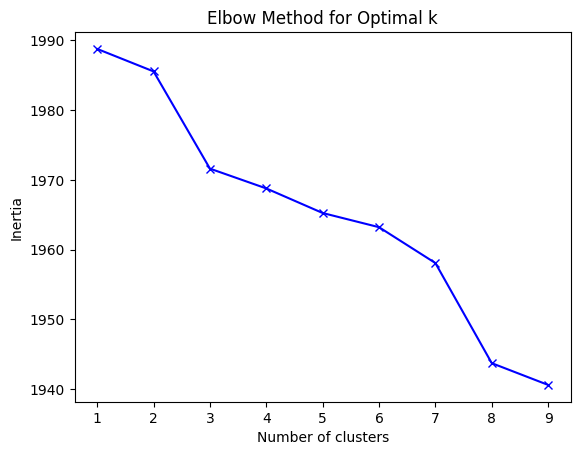

In [139]:
elbow(X_pca, end=10)

In [142]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_news['cluster'] = kmeans.fit_predict(X_pca)

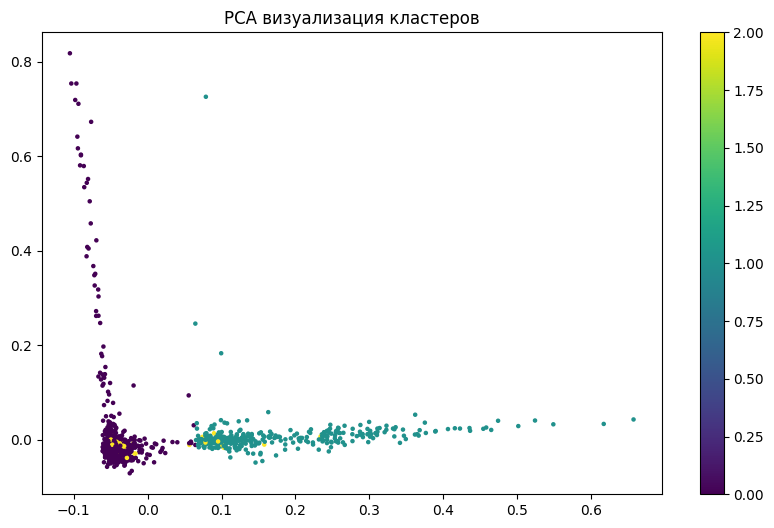

In [143]:
plt.figure(figsize=(10, 6))

plt.title('PCA визуализация кластеров')

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_news['cluster'], cmap='viridis', s=5)
plt.colorbar()
plt.show()

### Задача 3. 
Примените алгоритм K-Means к датасету [Wine Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/wine), чтобы выделить кластеры вин на основе их химического анализа.

In [27]:
wine = fetch_ucirepo(id=109) 
  
X = wine.data.features 
y = wine.data.targets 

df_wine = pd.DataFrame(data=X, columns=wine.feature_names)
df_wine['target'] = y


In [28]:
df_wine.head(7)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450,1
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290,1


In [29]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
 13  targe

In [30]:
df_wine.describe()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,1.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,1.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,2.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,3.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,3.000000


In [31]:
df_wine = df_wine[(np.abs(zscore(df_wine)) < 3).all(axis=1)]

df_wine.describe()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,13.033214,2.343571,2.369226,19.361310,98.779762,2.273988,2.010298,0.362679,1.553155,5.116726,0.951226,2.596607,752.875000,1.934524
std,0.793084,1.097823,0.243202,3.118708,12.560477,0.627890,0.985189,0.123940,0.529569,2.243267,0.220522,0.714607,319.272211,0.790209
min,11.410000,0.740000,1.700000,11.200000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,1.000000
25%,12.370000,1.610000,2.230000,17.175000,88.000000,1.700000,1.097500,0.270000,1.235000,3.292500,0.787500,1.905000,501.500000,1.000000
50%,13.060000,1.870000,2.360000,19.250000,97.500000,2.265000,2.100000,0.340000,1.505000,4.850000,0.960000,2.775000,675.000000,2.000000
75%,13.695000,3.105000,2.542500,21.500000,106.250000,2.800000,2.885000,0.430000,1.870000,6.262500,1.112500,3.170000,1016.250000,3.000000
max,14.830000,5.650000,2.920000,28.500000,136.000000,3.880000,3.930000,0.660000,2.960000,11.750000,1.450000,4.000000,1680.000000,3.000000


In [32]:
def cluster(df, model, n_clusters=0, target='target', eps=0):
    np.random.RandomState(42)

    X, y = df.drop(columns=[target]), df[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X, y)
    if n_clusters != 0:
        df['cluster'] = model(n_clusters=n_clusters).fit_predict(X_scaled, y)
    elif eps != 0:
        df['cluster'] = model(eps=eps).fit_predict(X_scaled, y)
    else:
        df['cluster'] = model().fit_predict(X_scaled, y)
        
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))

    plt.title('PCA визуализация кластеров')

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis')
    plt.colorbar()
    plt.show()

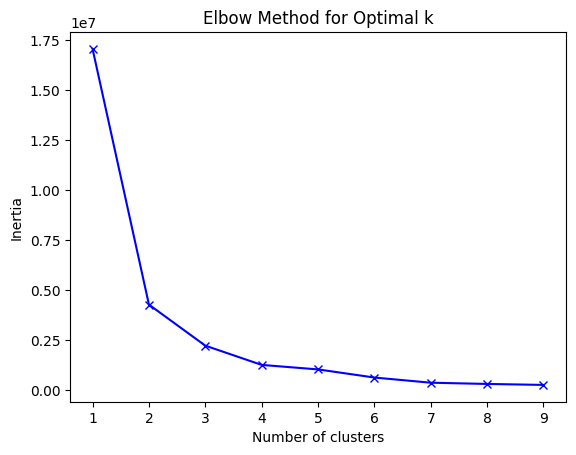

In [33]:
elbow(df_wine.drop(columns='target'))

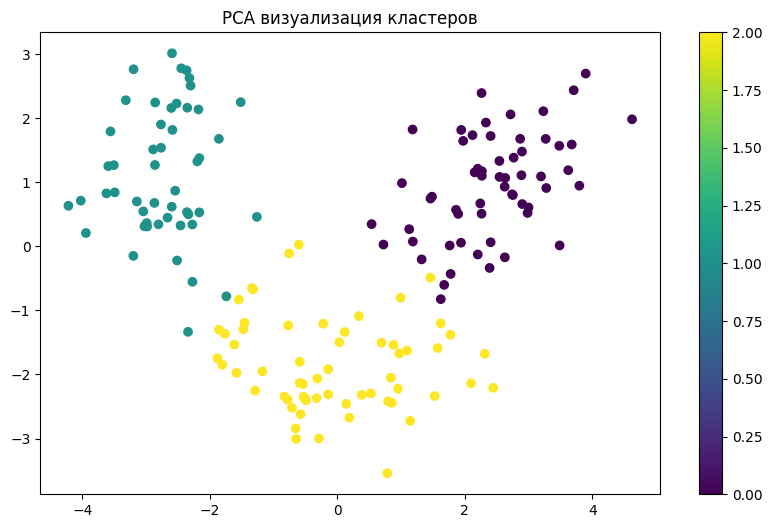

In [34]:
cluster(df_wine, KMeans, n_clusters=3)

### Задача 4. 
Разделите датасет [Wholesale Customers Data](https://archive.ics.uci.edu/ml/datasets/wholesale+customers) на категории. В этом датасете содержатся данные о расходах клиентов оптового дистрибьютора на разные категории продуктов. Цель - сегментировать клиентов по их годовым расходам на разные категории продуктов.

In [35]:
wholesale_customers = fetch_ucirepo(id=292) 
  
X = wholesale_customers.data.features 
y = wholesale_customers.data.targets 

df_customers = pd.DataFrame(data=X, columns=wholesale_customers.feature_names)
df_customers['target'] = y

In [36]:
df_customers.head(7)

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,target
0,2,12669,9656,7561,214,2674,1338,3
1,2,7057,9810,9568,1762,3293,1776,3
2,2,6353,8808,7684,2405,3516,7844,3
3,1,13265,1196,4221,6404,507,1788,3
4,2,22615,5410,7198,3915,1777,5185,3
5,2,9413,8259,5126,666,1795,1451,3
6,2,12126,3199,6975,480,3140,545,3


In [37]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Fresh             440 non-null    int64
 2   Milk              440 non-null    int64
 3   Grocery           440 non-null    int64
 4   Frozen            440 non-null    int64
 5   Detergents_Paper  440 non-null    int64
 6   Delicassen        440 non-null    int64
 7   target            440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [38]:
df_customers.describe()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,target
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,2.543182
std,0.468052,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,0.774272
min,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,1.000000
25%,1.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,2.000000
50%,1.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,3.000000
75%,2.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,3.000000
max,2.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,3.000000


In [39]:
df_customers = df_customers[(np.abs(zscore(df_customers)) < 3).all(axis=1)]

df_customers.describe()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.314010,10711.758454,4871.920290,6814.043478,2549.898551,2373.393720,1237.939614,2.548309
std,0.464682,9819.217756,4555.665546,6456.160715,2916.683284,3208.707909,1217.399162,0.769475
min,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,1.000000
25%,1.000000,3063.250000,1477.750000,2116.000000,676.750000,252.750000,395.000000,2.000000
50%,1.000000,8040.000000,3530.000000,4528.000000,1447.000000,772.000000,881.000000,3.000000
75%,2.000000,15657.000000,6908.500000,9762.250000,3204.250000,3660.500000,1681.750000,3.000000
max,2.000000,49063.000000,25862.000000,34792.000000,16919.000000,17120.000000,7844.000000,3.000000


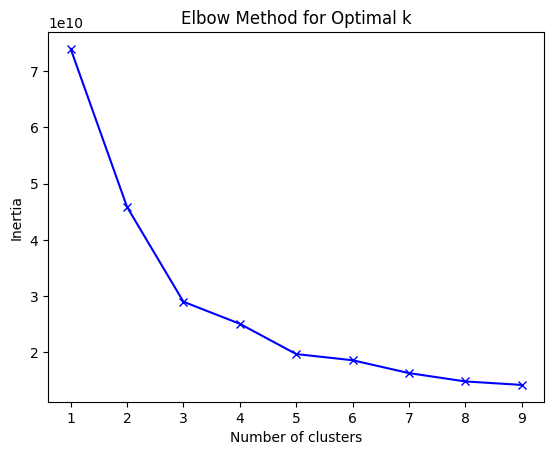

In [40]:
elbow(df_customers.drop(columns=['target']))

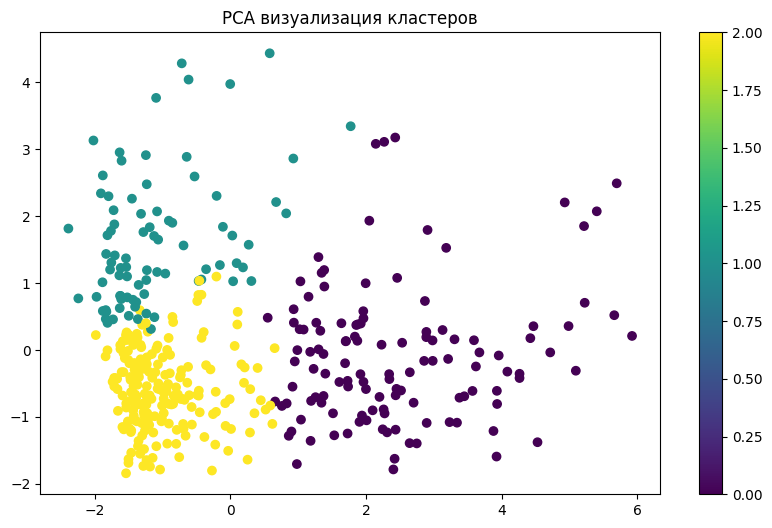

In [41]:
cluster(df_customers, KMeans, n_clusters=3)

## Иерархические алгоритмы.

### Задача 1. 
Примените иерархическую кластеризацию к набору данных [Iris](https://archive.ics.uci.edu/ml/datasets/Iris). Используйте дендрограмму для определения оптимального числа кластеров и сравните свои результаты с фактическими метками.

In [42]:
ds_iris = load_iris()

df_iris = pd.DataFrame(data=ds_iris.data, columns=ds_iris.feature_names)
df_iris['target'] = ds_iris.target

df_iris.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0


In [43]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [44]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [45]:
df_iris = df_iris[(np.abs(zscore(df_iris)) < 3).all(axis=1)]

df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,5.844295,3.048322,3.773154,1.204698,1.006711
std,0.830775,0.423085,1.761435,0.761962,0.817847
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.400000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.200000,6.900000,2.500000,2.000000


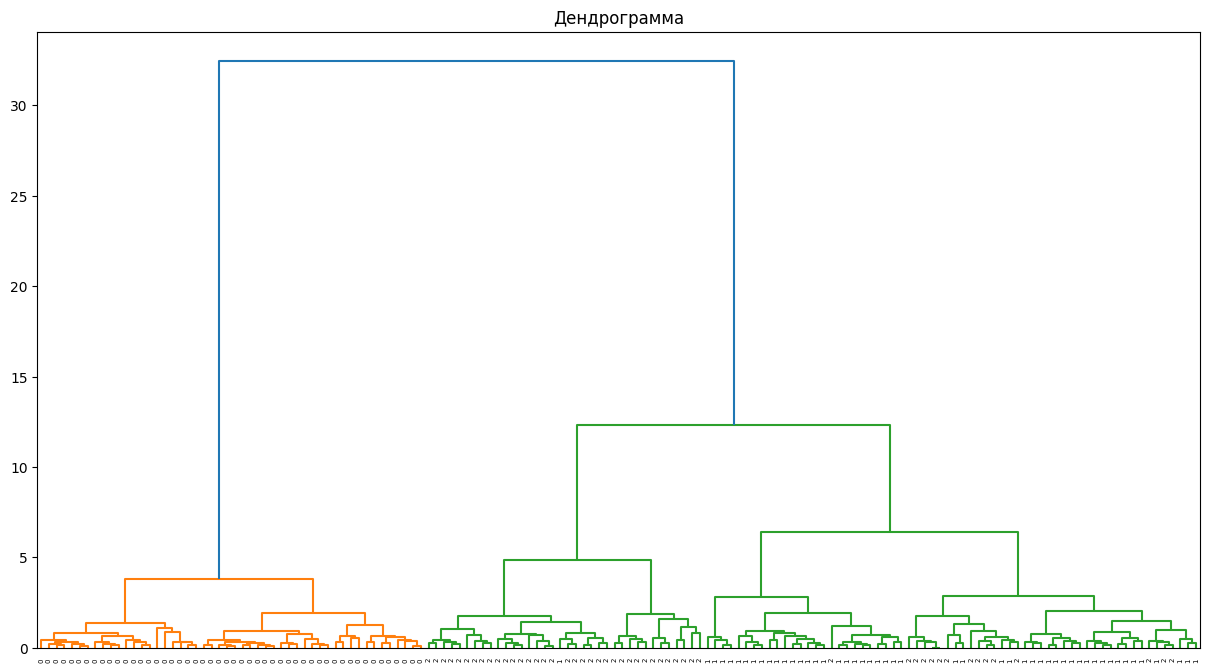

In [46]:
X, y = ds_iris.data, ds_iris.target

linked = linkage(X, 'ward')

plt.figure(figsize=(15, 8))

plt.title('Дендрограмма')

dendrogram(linked, orientation='top', labels=y)
plt.show()

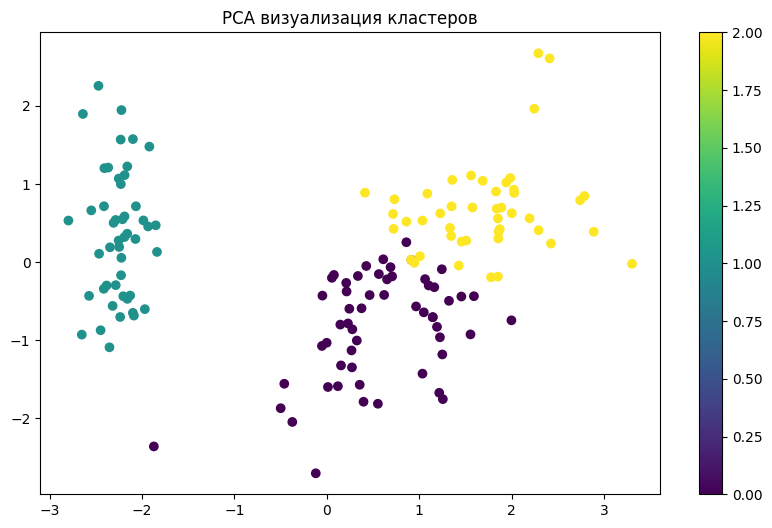

In [47]:
cluster(df_iris, AgglomerativeClustering, n_clusters=3)

In [48]:
print('Accuracy: ', accuracy_score(df_iris['target'], df_iris['cluster']))

Accuracy:  0.2483221476510067


### Задача 2.

Текстовый анализ. Используйте датасет [20 News Groups](http://qwone.com/~jason/20Newsgroups/), который включает в себя около 20 000 сообщений, сгруппированных примерно на 20 новостных групп. Ваша задача заключается в иерархической кластеризации данных с использованием любой техники векторизации текста.

In [144]:
newsgroups_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

df_news = pd.DataFrame(data=newsgroups_data.data, columns=['text'])
df_news['target'] = newsgroups_data.target

df_news = df_news.sample(3000).reset_index()

df_news.head(7)

,index,text,target
0,14991,From: presiden@fraser.sfu.ca (Pat Presidente)\...,2
1,10613,From: cmk@athena.mit.edu (Charles M Kozierok)\...,9
2,7538,From: s8719667@cse.unsw.edu.au (D W Austin)\nS...,1
3,2444,From: buck@HQ.Ileaf.COM (David Buchholz x3252)...,1
4,13706,From: jmg14@po.CWRU.Edu (John M. Graham)\nSubj...,4
5,6192,From: lairdb@crash.cts.com (Laird P. Broadfiel...,16
6,14883,From: galen@picea.CFNR.ColoState.EDU (Galen Wa...,12


In [145]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   3000 non-null   int64 
 1   text    3000 non-null   object
 2   target  3000 non-null   int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 58.7+ KB


In [146]:
df_news['transformed'] = transform(df_news['text'])

In [147]:
tfidf = TfidfVectorizer()

X_vectorized = tfidf.fit_transform(df_news['transformed'])
y = df_news['target']

scaler.fit(X_vectorized.toarray())

X_scaled = scaler.transform(X_vectorized.toarray())

X_pca = PCA(n_components=5).fit_transform(X_scaled)

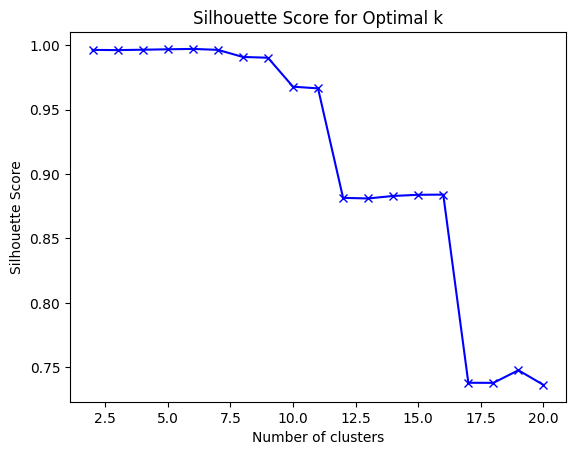

In [148]:
silhouette_scores = []

k_range = range(2, 21)

for k in k_range:
    clustering = AgglomerativeClustering(n_clusters=k).fit_predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, clustering))

plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

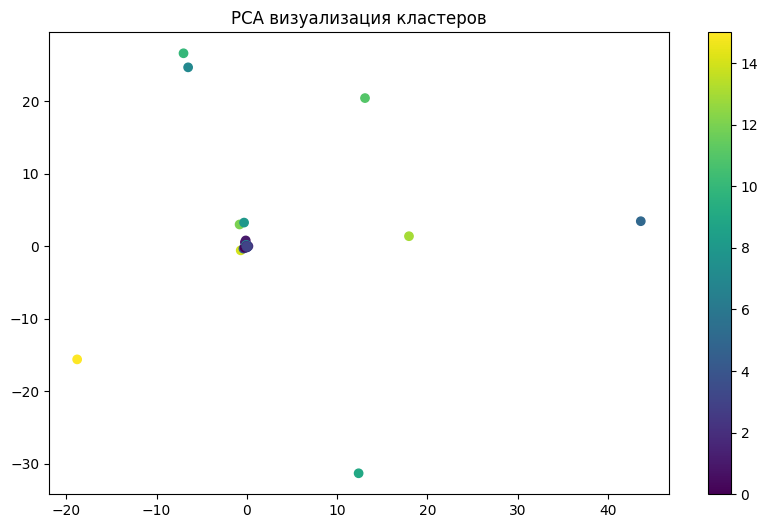

In [149]:
df = pd.DataFrame(data=X_pca, columns=['Component {i}' for i in range(5)])
df['target'] = y

cluster(df, AgglomerativeClustering, n_clusters=16)

### Задача 3. 

Получите данные о фильмах и их рейтинге (ссылка на данные: [Movies Dataset](https://www.kaggle.com/rounakbanik/movie-recommender-systems/data)). Ваша задача - с помощью иерархической кластеризации группировать фильмы по жанрам и средним рейтингам. 

In [55]:
df_movies = pd.read_csv(r'Datasets\movies_metadata.zip')

df_movies.head(7)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
5,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0


In [56]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [57]:
df_movies.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [58]:
df_movies = df_movies.dropna()

df_movies.isna().sum()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
dtype: int64

In [59]:
df_movies.describe()

,revenue,runtime,vote_average,vote_count
count,6.930000e+02,693.000000,693.000000,693.000000
mean,2.348037e+08,107.363636,6.270996,1691.366522
std,3.299089e+08,27.243771,1.012328,2215.285619
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,91.000000,5.800000,121.000000
50%,8.332000e+07,103.000000,6.300000,688.000000
75%,3.613666e+08,121.000000,7.000000,2491.000000
max,2.787965e+09,476.000000,8.500000,12269.000000


In [60]:
col = df_movies.describe().columns

df_movies[col] = df_movies[col][(np.abs(zscore(df_movies[col])) < 3).all(axis=1)]

df_movies.describe()

,revenue,runtime,vote_average,vote_count
count,6.590000e+02,659.000000,659.000000,659.000000
mean,2.094958e+08,106.157815,6.291199,1501.502276
std,2.746676e+08,21.681572,0.871055,1828.014103
min,0.000000e+00,30.000000,3.500000,1.000000
25%,0.000000e+00,91.000000,5.800000,133.500000
50%,8.216988e+07,102.000000,6.300000,671.000000
75%,3.347582e+08,120.000000,6.900000,2341.000000
max,1.156731e+09,185.000000,8.500000,7718.000000


In [61]:
df_movies['genre_code'] = pd.Categorical(df_movies['genres']).codes

df_movies.head(7)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genre_code
9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,352194034.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,51
68,False,"{'id': 43563, 'name': 'Friday Collection', 'po...",3500000,"[{'id': 35, 'name': 'Comedy'}]",http://www.newline.com/properties/friday.html,10634,tt0113118,en,Friday,Craig and Smokey are two guys in Los Angeles h...,...,28215918.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A lot can go down between thursday and saturda...,Friday,False,7.0,513.0,278
69,False,"{'id': 10924, 'name': 'From Dusk Till Dawn Col...",19000000,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,...,25836616.0,108.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644.0,149
153,False,"{'id': 439053, 'name': 'Brooklyn Cigar Store C...",2000000,"[{'id': 35, 'name': 'Comedy'}]",http://miramax.com/movie/blue-in-the-face/,5894,tt0112541,en,Blue in the Face,"Auggie runs a small tobacco shop in Brooklyn, ...",...,1275000.0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Welcome to the planet Brooklyn.,Blue in the Face,False,6.8,28.0,278
178,False,"{'id': 286162, 'name': 'Power Rangers Collecti...",15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.powerrangers.com/,9070,tt0113820,en,Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...,...,66000000.0,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Power Is On!,Mighty Morphin Power Rangers: The Movie,False,5.2,153.0,195
219,False,"{'id': 182813, 'name': 'Clerks Collection', 'p...",27000,"[{'id': 35, 'name': 'Comedy'}]",http://www.miramax.com/movie/clerks/,2292,tt0109445,en,Clerks,Convenience and video store clerks Dante and R...,...,3151130.0,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just because they serve you doesn't mean they ...,Clerks,False,7.4,769.0,278
256,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",11000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,11,tt0076759,en,Star Wars,Princess Leia is captured and held hostage by ...,...,775398007.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"A long time ago in a galaxy far, far away...",Star Wars,False,8.1,6778.0,53


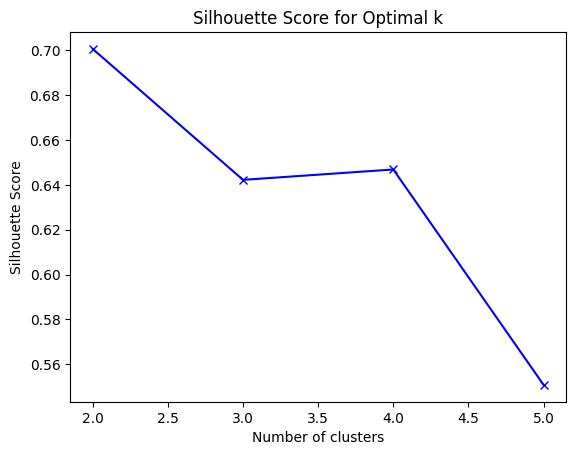

In [62]:
silhouette_scores = []

k_range = range(2, 6)

for k in k_range:
    clustering = AgglomerativeClustering(n_clusters=k).fit_predict(df_movies[['genre_code', 'vote_average', 'vote_count']].dropna())
    silhouette_scores.append(silhouette_score(df_movies[['genre_code', 'vote_average', 'vote_count']].dropna(), clustering))

plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

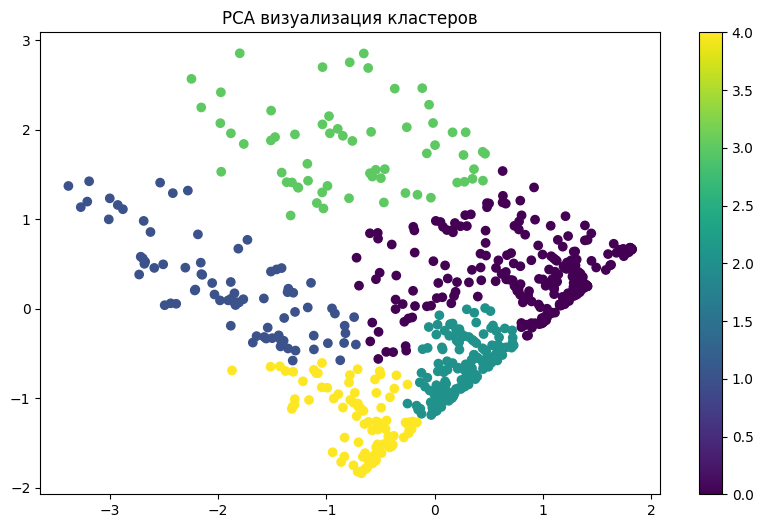

In [63]:
cluster(df_movies[['genre_code', 'vote_average', 'vote_count']].dropna(), AgglomerativeClustering, target='vote_average', n_clusters=5)

### Задача 4. 
Используйте набор данных [Seeds](https://archive.ics.uci.edu/ml/datasets/seeds) для кластеризации различных сортов пшеницы. Данный набор данных содержит измерения геометрических свойств семян семи различных видов пшеницы. Ваша задача провести иерархическую кластеризацию и визуализировать результаты с помощью дендрограммы.

In [64]:
df_seeds = pd.read_table(r'Datasets\seeds_dataset.txt', delimiter='\t', 
                         header=None, names=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'target'])

df_seeds.head(7)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1


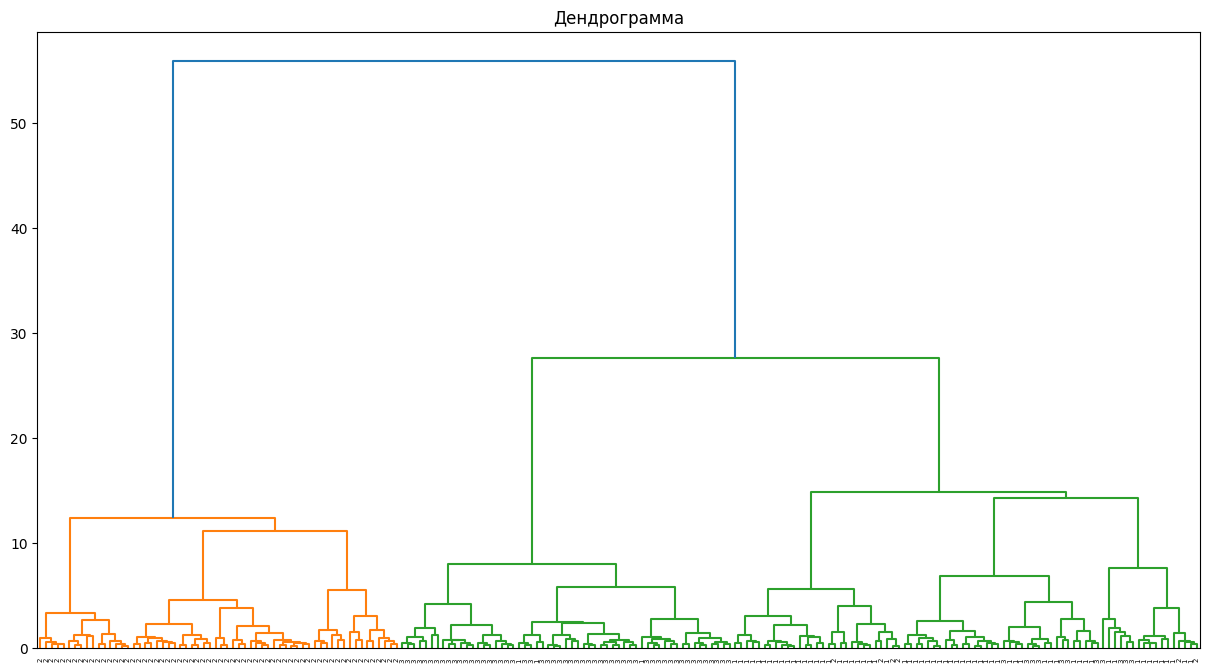

In [65]:
X, y = df_seeds.drop(columns=['target']), df_seeds.target.values

linked = linkage(X, 'ward')

plt.figure(figsize=(15, 8))

plt.title('Дендрограмма')

dendrogram(linked, orientation='top', labels=y)
plt.show()

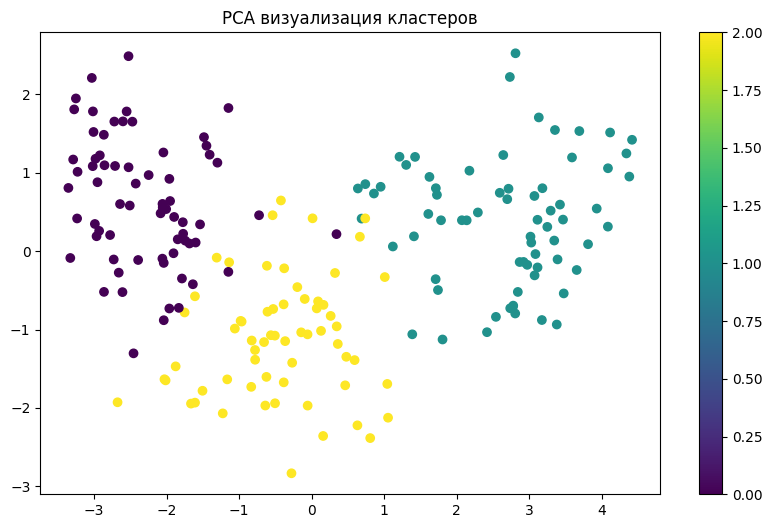

In [66]:
cluster(df_seeds, AgglomerativeClustering, n_clusters=3)

## DBSCAN.

### Задача 1. 
Используйте DBSCAN для кластеризации набора данных [Iris](https://archive.ics.uci.edu/ml/datasets/Iris). Сравните полученные результаты с изначальными метками. DBSCAN хорош для этой задачи, поскольку он может находить кластеры произвольной формы.

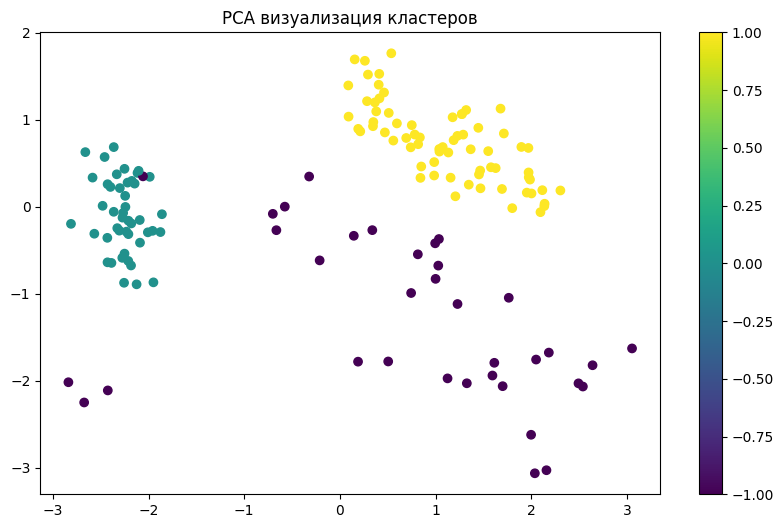

In [100]:
cluster(df_iris, DBSCAN, eps=0.6)

In [ ]:
plt.scatter(df_iris['sepal length (cm)'], df_iris['petal width (cm)'], df_iris['target'])

In [101]:
print('Accuracy: ', accuracy_score(df_iris['target'], df_iris['cluster']))

Accuracy:  0.5637583892617449


### Задача 2. 
Примените DBSCAN для кластеризации датасета [Moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) из библиотеки sklearn. Этот набор данных идеально подходит для демонстрации преимуществ DBSCAN, потому что он содержит два визуально различимых "месяца", и каждый из них должен стать отдельным кластером. 

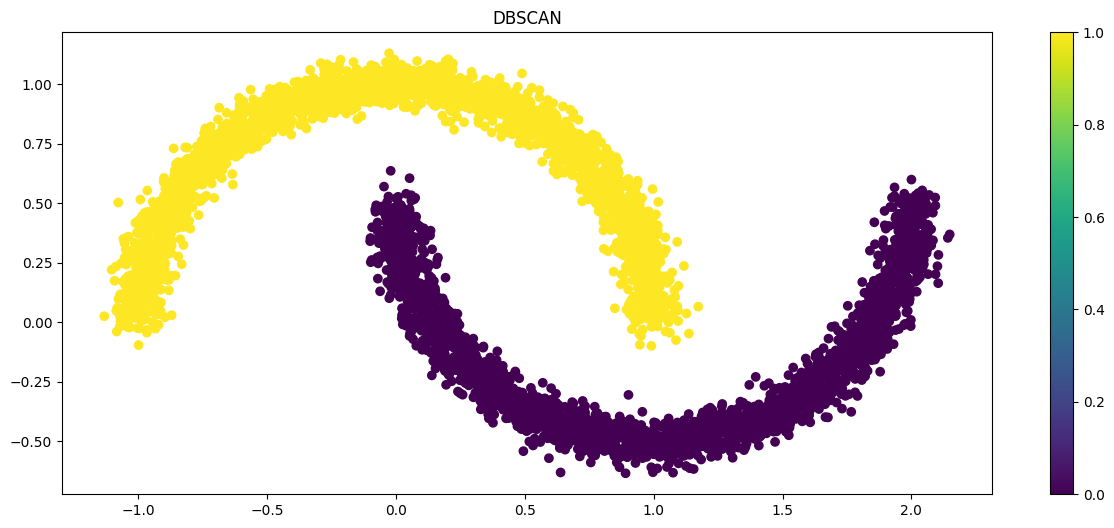

In [102]:
X, y = make_moons(n_samples=5000, noise=0.05)

dbscan = DBSCAN(eps=0.2, min_samples=5)
clusters = dbscan.fit_predict(X)

plt.figure(figsize=(15, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN')
plt.colorbar()
plt.show()

### Задача 3. 
Используйте пакет DBSCAN в Python для кластеризации геолокационных данных (например, [Geolife GPS Trajectories](https://archive.ics.uci.edu/ml/datasets/Geolife+Trajectories+1.3)). Целью будет выявление основных мест сбора/перехода на основе GPS-координат.

In [103]:
df_gps = pd.read_csv(r'Datasets\gps.csv').drop(columns='time')

df_gps.head(7)

,id,latitude,longitude,track_id
0,1,-10.939341,-37.062742,1
1,2,-10.939341,-37.062742,1
2,3,-10.939324,-37.062765,1
3,4,-10.939211,-37.062843,1
4,5,-10.938939,-37.062879,1
5,6,-10.938544,-37.062839,1
6,7,-10.938346,-37.062588,1


In [104]:
df_gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         18107 non-null  int64  
 1   latitude   18107 non-null  float64
 2   longitude  18107 non-null  float64
 3   track_id   18107 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 566.0 KB


In [105]:
df_gps.isna().sum()

id           0
latitude     0
longitude    0
track_id     0
dtype: int64

In [106]:
df_gps.describe()

,id,latitude,longitude,track_id
count,18107.000000,18107.000000,18107.000000,18107.000000
mean,9958.405920,-10.998744,-37.111923,13296.340697
std,5748.673657,1.329848,0.938015,18040.767448
min,1.000000,-27.603175,-48.632918,1.000000
25%,4736.500000,-10.944041,-37.073069,33.000000
50%,10376.000000,-10.922000,-37.057784,136.000000
75%,15004.500000,-10.904268,-37.050190,37992.000000
max,19569.000000,-10.292845,-36.493357,38092.000000


In [107]:
df_gps.isna().sum()

id           0
latitude     0
longitude    0
track_id     0
dtype: int64

In [108]:
col = df_gps.describe().columns

df_gps= df_gps[(np.abs(zscore(df_gps)) < 3).all(axis=1)]

df_gps.describe()

,id,latitude,longitude,track_id
count,17989.000000,17989.000000,17989.000000,17989.000000
mean,9975.309300,-10.891588,-37.036421,13383.195508
std,5763.695188,0.134148,0.104181,18067.836003
min,1.000000,-11.015496,-37.535886,1.000000
25%,4707.000000,-10.943853,-37.073032,33.000000
50%,10435.000000,-10.921791,-37.057649,136.000000
75%,15034.000000,-10.904213,-37.050079,37992.000000
max,19569.000000,-10.292845,-36.493357,38092.000000


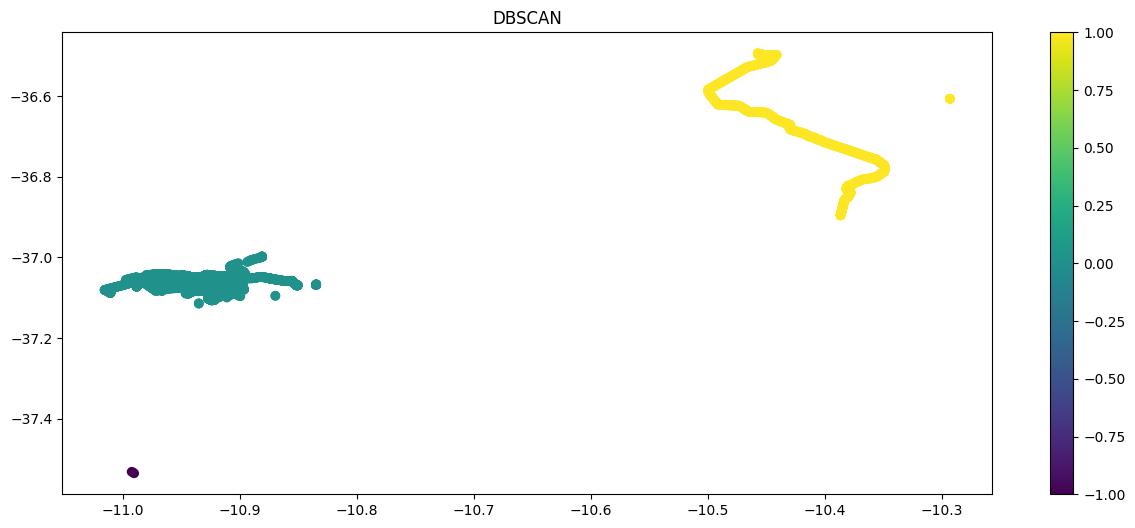

In [109]:
df_coords = pd.DataFrame(df_gps[['latitude', 'longitude']].to_numpy())

dbscan = DBSCAN(eps=0.005, min_samples=5, algorithm='ball_tree')
clusters = dbscan.fit_predict(np.radians(df_coords))

df_gps['cluster'] = clusters

plt.figure(figsize=(15, 6))
plt.scatter(df_coords[0], df_coords[1], c=clusters, cmap='viridis')
plt.title('DBSCAN')
plt.colorbar()
plt.show()